In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree

In [2]:
def get_rules(df, tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)
    
    features_list = []
    cond_list = []
    values_list = []
    means_list = []
    sample_list = []
    for path in paths:
        features = []
        cond = []
        values = []
        for i in range(len(path)-1):
            pathn = path[i][1:-1]
            pathn1 = pathn.split(' ')[0]
            cond1 = pathn.split(' ')[1]
            values1 = float(pathn.split(' ')[2])
            
            features.append(pathn1)
            cond.append(cond1)
            values.append(values1)
               
        features_list.append(features)
        cond_list.append(cond)
        values_list.append(values)
        means = float(path[-1][0][0][0])
        sample = int(path[-1][1])
        means_list.append(means)
        sample_list.append(sample)
        
    child_list = np.arange(1, len(features_list)+1)
    df['ChildNo'] = -1
    df['NoOfSamples'] = -1
    df['Means'] = -1
    for i,j, k, m, n, o in zip(features_list, cond_list, values_list, child_list, means_list, sample_list):
        print(i,j, k, m, n, o)
        for l in range(len(j)):
            if j[l]=='>':
                cond1 = (df[i[l]] > k[l])
            else:
                cond1 = (df[i[l]] <= k[l])
            if l == 0:
                cond2 = cond1.copy()
                #print('cond1 : \n', cond2)
            else:
                cond2 = (cond1 & cond2)
                #print('cond2 : \n', cond3)
        df['ChildNo'] = np.where(cond2, m, df['ChildNo'])
        df['NoOfSamples'] = np.where(cond2, o, df['NoOfSamples'])
        df['Means'] = np.where(cond2, n, df['Means'])
    return df

## Decision Tree to Datafrmae using 3 predictor variable

In [3]:
cols = ['Height','FavoriteColor','Gender','Weight']
data = [[1.6,'Blue','Male',88],
[1.6,'Green','Female',76],
[1.5,'Blue','Female',56],
[1.8,'Red','Male',73],
[1.5,'Green','Male',77],
[1.4,'Blue','Female',57]]
df0 = pd.DataFrame(data = data, columns=cols)
df0

,Height,FavoriteColor,Gender,Weight
0,1.6,Blue,Male,88
1,1.6,Green,Female,76
2,1.5,Blue,Female,56
3,1.8,Red,Male,73
4,1.5,Green,Male,77
5,1.4,Blue,Female,57


In [4]:
df = df0.replace({'Red': 1, 'Green': 2, 'Blue': 3, 'Female': 0, 'Male': 1})
df

,Height,FavoriteColor,Gender,Weight
0,1.6,3,1,88
1,1.6,2,0,76
2,1.5,3,0,56
3,1.8,1,1,73
4,1.5,2,1,77
5,1.4,3,0,57


In [5]:
X_train = df.iloc[:, :-1]
feature_names = list(X_train.columns)
Y_train = df.iloc[:, -1]
target_name = Y_train.name

### Max Depth = 3

In [6]:
dtr = DecisionTreeRegressor(max_depth=3)  # max_depth=2
dtr.fit(X_train, Y_train)
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [7]:
text_rule = tree.export_text(dtr, feature_names=feature_names)
print(text_rule)

|--- Gender <= 0.50
|   |--- FavoriteColor <= 2.50
|   |   |--- value: [76.00]
|   |--- FavoriteColor >  2.50
|   |   |--- Height <= 1.45
|   |   |   |--- value: [57.00]
|   |   |--- Height >  1.45
|   |   |   |--- value: [56.00]
|--- Gender >  0.50
|   |--- FavoriteColor <= 2.50
|   |   |--- FavoriteColor <= 1.50
|   |   |   |--- value: [73.00]
|   |   |--- FavoriteColor >  1.50
|   |   |   |--- value: [77.00]
|   |--- FavoriteColor >  2.50
|   |   |--- value: [88.00]



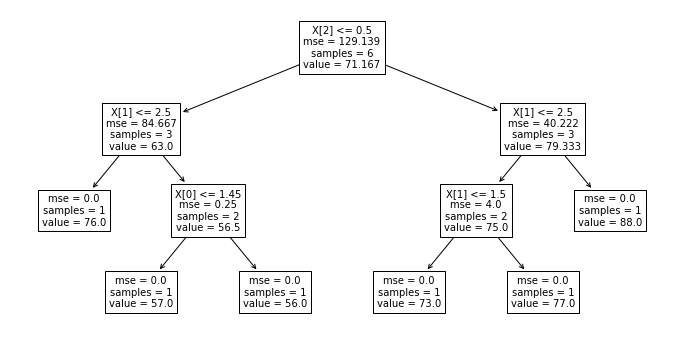

In [8]:
# plot tree
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))  # set plot size (denoted in inches)
tree.plot_tree(dtr, fontsize=10)
plt.show()

In [9]:
df0 #[6,3,2,4,5,1]

,Height,FavoriteColor,Gender,Weight
0,1.6,Blue,Male,88
1,1.6,Green,Female,76
2,1.5,Blue,Female,56
3,1.8,Red,Male,73
4,1.5,Green,Male,77
5,1.4,Blue,Female,57


In [10]:
dfn = get_rules(df, dtr, feature_names, target_name)
dfn

['Gender', 'FavoriteColor'] ['<=', '<='] [0.5, 2.5] 1 76.0 1
['Gender', 'FavoriteColor', 'Height'] ['<=', '>', '<='] [0.5, 2.5, 1.45] 2 57.0 1
['Gender', 'FavoriteColor', 'Height'] ['<=', '>', '>'] [0.5, 2.5, 1.45] 3 56.0 1
['Gender', 'FavoriteColor', 'FavoriteColor'] ['>', '<=', '<='] [0.5, 2.5, 1.5] 4 73.0 1
['Gender', 'FavoriteColor', 'FavoriteColor'] ['>', '<=', '>'] [0.5, 2.5, 1.5] 5 77.0 1
['Gender', 'FavoriteColor'] ['>', '>'] [0.5, 2.5] 6 88.0 1


,Height,FavoriteColor,Gender,Weight,ChildNo,NoOfSamples,Means
0,1.6,3,1,88,6,1,88.0
1,1.6,2,0,76,1,1,76.0
2,1.5,3,0,56,3,1,56.0
3,1.8,1,1,73,4,1,73.0
4,1.5,2,1,77,5,1,77.0
5,1.4,3,0,57,2,1,57.0


## Max Depth = 2

In [11]:
dtr = DecisionTreeRegressor(max_depth=2)
dtr.fit(X_train, Y_train)
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [12]:
text_rule = tree.export_text(dtr, feature_names=feature_names)
print(text_rule)

|--- Gender <= 0.50
|   |--- Height <= 1.55
|   |   |--- value: [56.50]
|   |--- Height >  1.55
|   |   |--- value: [76.00]
|--- Gender >  0.50
|   |--- FavoriteColor <= 2.50
|   |   |--- value: [75.00]
|   |--- FavoriteColor >  2.50
|   |   |--- value: [88.00]



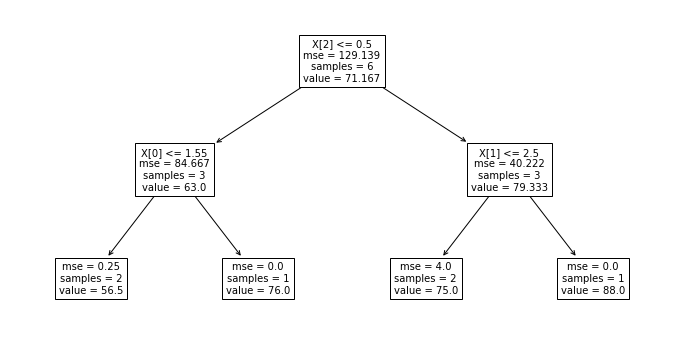

In [13]:
# plot tree
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))  # set plot size (denoted in inches)
tree.plot_tree(dtr, fontsize=10)
plt.show()

In [14]:
df0 #[4,2,1,3,3,1]

,Height,FavoriteColor,Gender,Weight
0,1.6,Blue,Male,88
1,1.6,Green,Female,76
2,1.5,Blue,Female,56
3,1.8,Red,Male,73
4,1.5,Green,Male,77
5,1.4,Blue,Female,57


In [15]:
dfn = get_rules(df, dtr, feature_names, 'Weight')
dfn

['Gender', 'Height'] ['<=', '<='] [0.5, 1.55] 1 56.5 2
['Gender', 'Height'] ['<=', '>'] [0.5, 1.55] 2 76.0 1
['Gender', 'FavoriteColor'] ['>', '<='] [0.5, 2.5] 3 75.0 2
['Gender', 'FavoriteColor'] ['>', '>'] [0.5, 2.5] 4 88.0 1


,Height,FavoriteColor,Gender,Weight,ChildNo,NoOfSamples,Means
0,1.6,3,1,88,4,1,88.0
1,1.6,2,0,76,2,1,76.0
2,1.5,3,0,56,1,2,56.5
3,1.8,1,1,73,3,2,75.0
4,1.5,2,1,77,3,2,75.0
5,1.4,3,0,57,1,2,56.5


## Decision Tree to Datafrmae using 1 predictor variable

In [16]:
year = [5,7,12,23,25,28,29,34,35,40]
salary = [82,80,103,118,172,127,204,189,99,166]
df = pd.DataFrame(columns=['Years','Salary'])
df.Years = year
df.Salary = salary
df0 = df.copy()
df

,Years,Salary
0,5,82
1,7,80
2,12,103
3,23,118
4,25,172
5,28,127
6,29,204
7,34,189
8,35,99
9,40,166


In [17]:
X_train = df.iloc[:, :-1]
feature_names = list(X_train.columns)
Y_train = df.iloc[:, -1]
target_name = Y_train.name

In [18]:
dtr = DecisionTreeRegressor(max_depth=2)
dtr.fit(X_train, Y_train)
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

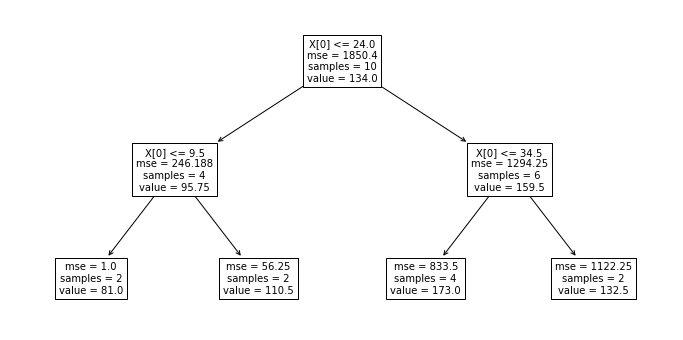

In [19]:
# plot tree
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))  # set plot size (denoted in inches)
tree.plot_tree(dtr, fontsize=10)
plt.show()

In [20]:
dfn = get_rules(df, dtr, feature_names, target_name)
dfn

['Years', 'Years'] ['<=', '<='] [24.0, 9.5] 1 81.0 2
['Years', 'Years'] ['<=', '>'] [24.0, 9.5] 2 110.5 2
['Years', 'Years'] ['>', '<='] [24.0, 34.5] 3 173.0 4
['Years', 'Years'] ['>', '>'] [24.0, 34.5] 4 132.5 2


,Years,Salary,ChildNo,NoOfSamples,Means
0,5,82,1,2,81.0
1,7,80,1,2,81.0
2,12,103,2,2,110.5
3,23,118,2,2,110.5
4,25,172,3,4,173.0
5,28,127,3,4,173.0
6,29,204,3,4,173.0
7,34,189,3,4,173.0
8,35,99,4,2,132.5
9,40,166,4,2,132.5
